<a href="https://colab.research.google.com/github/Saroramath/MachineLearning/blob/main/6205A/6205A6ConvoAutoEncoderWD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import math


# Prepare the dataset

> Step 1: Load the data

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


> Step 2: Normalize the images

In [5]:
def normalize_img(image, label):
  return tf.cast(image, tf.float32) / 255., label

In [6]:
ds_train = ds_train.map(normalize_img)
ds_test = ds_test.map(normalize_img)

> Step 3: Convert to dataframes

In [7]:
df_train = tfds.as_dataframe(ds_train, ds_info)
df_test = tfds.as_dataframe(ds_test,ds_info)

In [8]:
df_train.info()

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   60000 non-null  object
 1   label   60000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 937.6+ KB


In [9]:
df_test.info()

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   10000 non-null  object
 1   label   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


> Step 4: Combine train and test dataframes to increase the dataset

> Step 5: Create the synthetic data

In [16]:
df0=df_train.loc[lambda df_train: df_train['label'] == 0, :]

In [17]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5923 entries, 2 to 59979
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   5923 non-null   object
 1   label   5923 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 138.8+ KB


In [18]:
df6 = df_train.loc[lambda df_train: df_train['label'] == 6, :]

In [19]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5918 entries, 9 to 59997
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   5918 non-null   object
 1   label   5918 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 138.7+ KB


In [20]:
df6 = df6[:500]

In [21]:
df6.image[9].shape

(28, 28, 1)

In [22]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 9 to 4763
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   500 non-null    object
 1   label   500 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 31.7+ KB


In [23]:
df_new = df0.append(df6)

In [24]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6423 entries, 2 to 4763
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   6423 non-null   object
 1   label   6423 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 150.5+ KB


## Split the data in taining and test data

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
dftrain, dftest = train_test_split(df_new, test_size=0.20, random_state=42)

In [27]:
num_anomo = dftest.label[dftest.label==6].count()
print(num_anomo)

107


> There are 102 anomolies in the test data.

We will only train with the 0 label so we should choose that from the new training data so we do not use anything separarted out for testing.

In [28]:
df_0train = dftrain.loc[lambda dftrain: dftrain['label'] == 0, :]

In [29]:
df_0train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4745 entries, 23307 to 8517
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   4745 non-null   object
 1   label   4745 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 111.2+ KB


In [ ]:
#x_train = np.array(df_0train['image'])    Not givig an array of right size 
#y_train = np.array(df_0train['label'])# all values 0

In [30]:
data = []
for x in df_0train.image:
  data.append(x)
x_train = np.array(data).reshape(-1,28,28)


In [32]:
x_train.shape

(4745, 28, 28)

In [33]:
data = []
for x in df_0train.label:
  data.append(x)
y_train = np.array(data) 

In [34]:
y_train.shape

(4745,)

In [35]:
data = []
for x in dftest.image:
  data.append(x)
x_test = np.array(data).reshape(-1,28,28)

In [36]:
x_test.shape

(1285, 28, 28)

In [37]:
data = []
for x in dftest.label:
  data.append(x)
y_test = np.array(data)  

In [38]:
y_test.shape

(1285,)

# Model: Convolutional Autoencoder

In [132]:
encoder = tf.keras.models.Sequential([
          tf.keras.layers.Reshape([28,28,1],input_shape=[28,28]),                          
          tf.keras.layers.Conv2D(2,kernel_size=3,strides=2,padding='same', activation='relu'), 
          #tf.keras.layers.Conv2D(32,kernel_size=3,strides=2,padding='same', activation='relu'), 
          ])
decoder = tf.keras.models.Sequential([
         # tf.keras.layers.Conv2DTranspose(32,kernel_size=3,strides=2,padding='same', activation='relu'),
          tf.keras.layers.Conv2DTranspose(2,kernel_size=3,strides=2,padding='same', activation='relu'),
          tf.keras.layers.Conv2D(1,kernel_size=3,padding='same', activation='sigmoid'),
          tf.keras.layers.Reshape([28,28])])

autoencoder = tf.keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss = 'mse', optimizer = 'adam')




In [133]:
encoder.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 2)         20        
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


In [134]:
decoder.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 2)         38        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 1)         19        
_________________________________________________________________
reshape_8 (Reshape)          (None, 28, 28)            0         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [135]:
history= autoencoder.fit(x_train,x_train,epochs=20)

Epoch 1/20
149/149 [==============================] - 3s 16ms/step - loss: 0.2123
Epoch 2/20
149/149 [==============================] - 2s 16ms/step - loss: 0.0708
Epoch 3/20
149/149 [==============================] - 2s 16ms/step - loss: 0.0156
Epoch 4/20
149/149 [==============================] - 2s 16ms/step - loss: 0.0082
Epoch 5/20
149/149 [==============================] - 2s 17ms/step - loss: 0.0057
Epoch 6/20
149/149 [==============================] - 3s 17ms/step - loss: 0.0046
Epoch 7/20
149/149 [==============================] - 2s 16ms/step - loss: 0.0040
Epoch 8/20
149/149 [==============================] - 2s 16ms/step - loss: 0.0036
Epoch 9/20
149/149 [==============================] - 2s 15ms/step - loss: 0.0033
Epoch 10/20
149/149 [==============================] - 2s 15ms/step - loss: 0.0031
Epoch 11/20
149/149 [==============================] - 2s 15ms/step - loss: 0.0029
Epoch 12/20
149/149 [==============================] - 2s 16ms/step - loss: 0.0028
Epoch 13/20
1

In [136]:
decoded_imgs=autoencoder.predict(x_train)

## Visualize the reconstruction

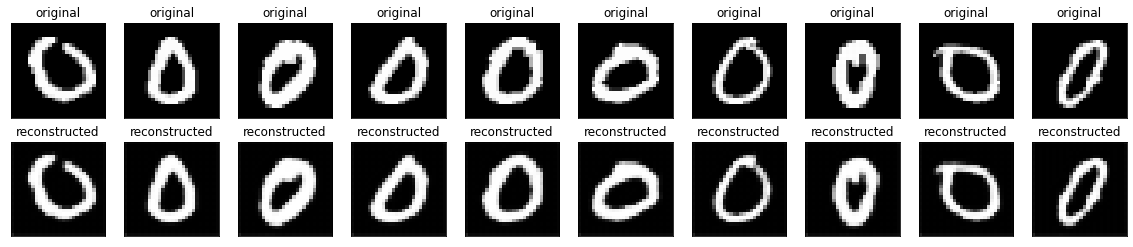

In [137]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_train[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Absolute error in reconstruction

In [138]:
abs = np.abs(decoded_imgs - x_train)
abs = abs.reshape(-1, 28*28)


In [139]:
abs.shape

(4745, 784)

In [140]:
loss = np.mean(abs, axis=1)

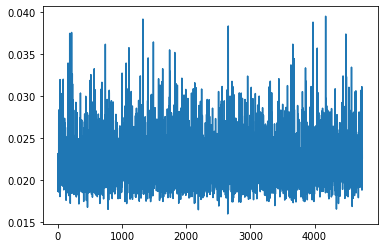

In [141]:
plt.plot(loss)

> We observe that there is a lot of loss among the regular images set itself. So it will be difficult to seperate anomoloies.

In [142]:
max_loss = loss.max()

In [143]:
max_loss

0.039466508

In [144]:
loss.min()

0.01595958

In [145]:
max_loss_index = np.where(loss == max_loss)

> Visulatze image with maximum error

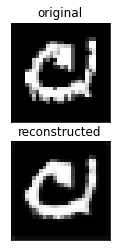

In [146]:
n = 1
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_train[max_loss_index].reshape(28,28))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[max_loss_index].reshape(28,28))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [147]:
mean_loss = loss.mean()

In [148]:
variance_loss = loss.var()

## Assign threshold

> We will assign the threshhold as the largest reconstruction error excluding 0.01% worst reconstructed regular images.

In [149]:
t = math.floor(0.01*5524)
print(t)

55


In [150]:
mean_loss + variance_loss

0.022286922

In [151]:
ind_max = np.argpartition(loss, -t)[-t:]

In [152]:
ind_max

array([1856, 3946,  683, 4488,   83, 1749, 1488, 4042, 1822, 1741, 3310,
       3859, 4444, 1325, 1284, 3683,  158, 3444, 3974, 2133, 3307,  739,
       3632, 4497, 1107,  184, 3976, 1622,  514, 1862, 2713, 1594,  566,
       1633, 3867,   33, 2957, 1000,  213, 3578, 3661,  686,  498, 2655,
        224,  228, 1843, 2559, 1406, 4173, 2726, 1932, 1063, 4576, 1569])

In [153]:
threshold = loss[ind_max[0]]

In [154]:
#threshold = 0.0175

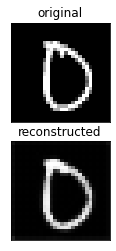

In [155]:
n = 1
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_train[ind_max[0]].reshape(28,28))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[ind_max[0]].reshape(28,28))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

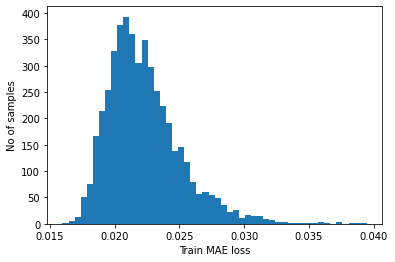

In [156]:
plt.hist(loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Prediction 

In [157]:
decoded_test = autoencoder.predict(x_test)

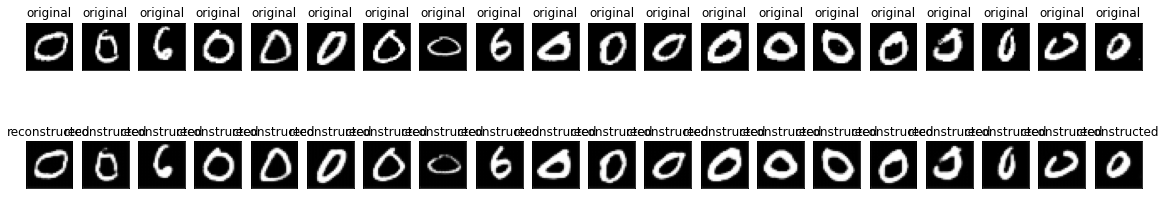

In [158]:
n = 20
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i].reshape(28,28))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_test[i].reshape(28,28))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

> We can see model is performing bad on anomolies

# Assign Anomoly

In [159]:
abs_test = (np.abs(decoded_test - x_test)).reshape(-1,28*28)

In [160]:
loss_test = np.mean(abs_test, axis=1)

In [161]:
loss_test.max()

0.037194084

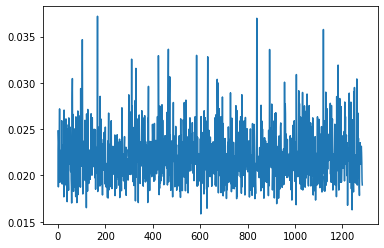

In [162]:
plt.plot(loss_test)

In [163]:
threshold

0.031095559

In [164]:
# Detect all the samples which are anomalies.
anomalies = loss_test > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  13
Indices of anomaly samples:  (array([ 103,  167,  311,  329,  424,  465,  466,  585,  632,  839,  893,
       1120, 1182]),)


In [165]:
predicted_anomoloies = anomalies.nonzero()

In [166]:
x_test.shape

(1285, 28, 28)

In [167]:
#np.array(predicted_anomoloies).reshape(-1).tolist() converted to list

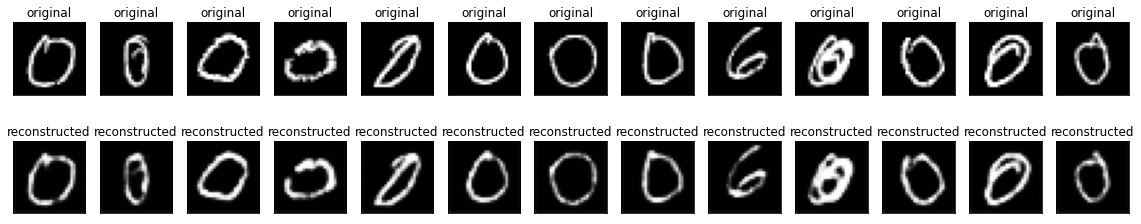

In [168]:
x = np.array(predicted_anomoloies).reshape(-1)[:15]
n = len(x)
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[x[i]].reshape(28,28))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_test[x[i]].reshape(28,28))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

Check the accuracy of the anomolies detected.

In [169]:
label_predicted =  np.array(np.where(anomalies))

In [170]:
label_predicted =  label_predicted.reshape(-1)

In [171]:
TP = 0
FP = 0
for i in label_predicted:
  if y_test[i] == 6:
    TP = TP+1
  else:
    FP = FP + 1  
FN = num_anomo - TP

In [172]:
TP

1

In [173]:
FP

12

In [174]:
Precision = (TP)/(TP+FP)
print(Precision)

0.07692307692307693


In [175]:
Recall = (TP)/(TP+FN)
print(Recall)

0.009345794392523364


# SSIM



In [176]:
x_train_new = np.expand_dims(x_train, axis = 3)
decoded_imgs_new = np.expand_dims(decoded_imgs, axis = 3)

In [177]:
SSIM_regular = tf.image.ssim(x_train_new, decoded_imgs_new,max_val=1).numpy()

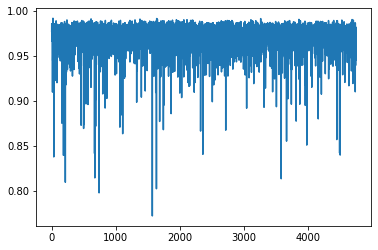

In [178]:
plt.plot(SSIM_regular)

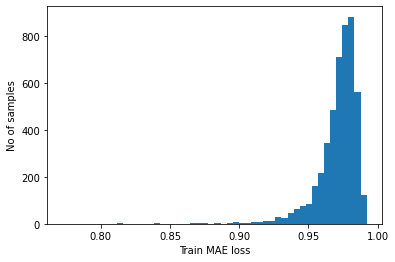

In [179]:
plt.hist(SSIM_regular, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

In [180]:
SSIM_regular.mean()

0.9709499

In [181]:
np.median(SSIM_regular)

0.974786

In [182]:
np.percentile(SSIM_regular,1)

0.907732961177826

> SSIM on test data

In [183]:
x_test_new = np.expand_dims(x_test, axis = 3)
decoded_test_new= np.expand_dims(decoded_test, axis = 3)

In [184]:
SSIM = tf.image.ssim(decoded_test_new, x_test_new,max_val=1).numpy()

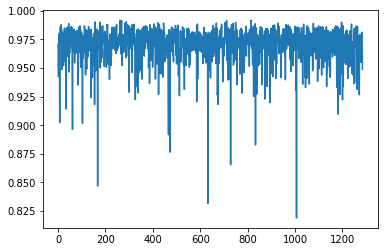

In [185]:
plt.plot(SSIM)

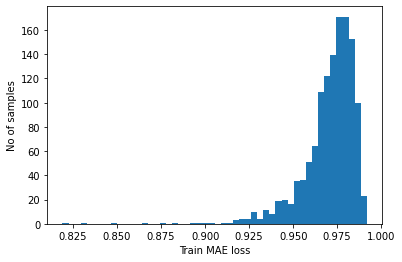

In [186]:
plt.hist(SSIM, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

In [187]:
SSIM.mean()

0.97021884

In [188]:
np.median(SSIM)

0.9738523

In [189]:
SSIM_test = np.percentile(SSIM, 1)

> We can observe that test data has done worse than regular images with only 0 labels on SSIM 

## Assign Anomoly

In [218]:
threshold = np.percentile(SSIM_regular,0.5)

In [219]:
# Detect all the samples which are anomalies.
anomalies = SSIM < threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  4
Indices of anomaly samples:  (array([ 167,  632,  728, 1006]),)


In [220]:
predicted_anomoloies = anomalies.nonzero()

In [221]:
x_test.shape

(1285, 28, 28)

In [222]:
#np.array(predicted_anomoloies).reshape(-1).tolist() converted to list

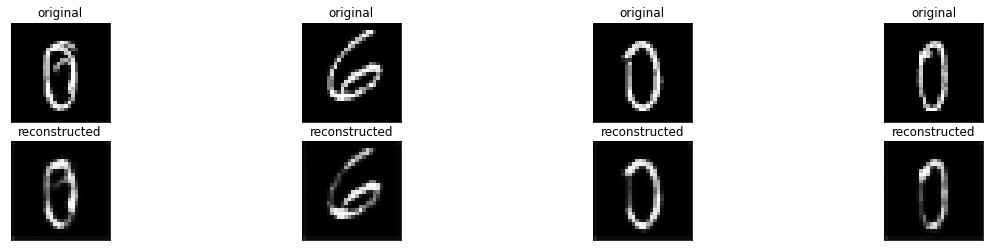

In [223]:
x = np.array(predicted_anomoloies).reshape(-1)[:15]
n = len(x)
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[x[i]].reshape(28,28))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_test[x[i]].reshape(28,28))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

Check the accuracy of the anomolies detected.

In [224]:
label_predicted =  np.array(np.where(anomalies))

In [225]:
label_predicted =  label_predicted.reshape(-1)

In [226]:
TP = 0
FP = 0
for i in label_predicted:
  if y_test[i] == 6:
    TP = TP+1
  else:
    FP = FP + 1  
FN = num_anomo - TP

In [227]:
TP

1

In [228]:
FP

3

In [229]:
Precision = (TP)/(TP+FP)
print(Precision)

0.25


In [230]:
Recall = (TP)/(TP+FN)
print(Recall)

0.009345794392523364


## Assign Anomoly with another threshold





In [260]:
threshold = np.percentile(SSIM_regular,1)

In [261]:
# Detect all the samples which are anomalies.
anomalies = SSIM < threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  10
Indices of anomaly samples:  (array([   7,   61,  103,  167,  466,  472,  632,  728,  833, 1006]),)


In [262]:
predicted_anomoloies = anomalies.nonzero()

In [263]:
x_test.shape

(1285, 28, 28)

In [264]:
#np.array(predicted_anomoloies).reshape(-1).tolist() converted to list

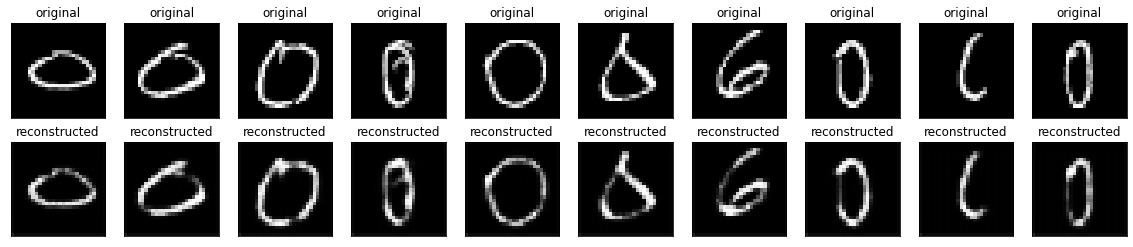

In [265]:
x = np.array(predicted_anomoloies).reshape(-1)[:15]
n = len(x)
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[x[i]].reshape(28,28))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_test[x[i]].reshape(28,28))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

Check the accuracy of the anomolies detected.

In [266]:
label_predicted =  np.array(np.where(anomalies))

In [267]:
label_predicted =  label_predicted.reshape(-1)

In [268]:
TP = 0
FP = 0
for i in label_predicted:
  if y_test[i] == 6:
    TP = TP+1
  else:
    FP = FP + 1  
FN = num_anomo - TP

In [269]:
TP

2

In [270]:
FP

8

In [271]:
FN

105

In [272]:
Precision = (TP)/(TP+FP)
print(Precision)

0.2


In [273]:
Recall = (TP)/(TP+FN)
print(Recall)

0.018691588785046728


# Conclusion

> We have not considered the test_data in dataset for regular images to remove some of the badly shaped regular images.

> The data is very noisy, and convolutional network is a very powerful network, and even reducing the parameters, the network is able to reconstruct unseen shapes, here 6, even while training on 0. Making it very inefficient to use autoencoders for anomoly detection.